# Assignment 1
Name: Vo, Huynh Quang Nguyen

CWID: A20446163

In [1]:
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt

### Problem 1

### Problem 2
Note: in this problem, I tried to get the same result as in the given example (in Figure 1).

(10000, 2)
(10000,)


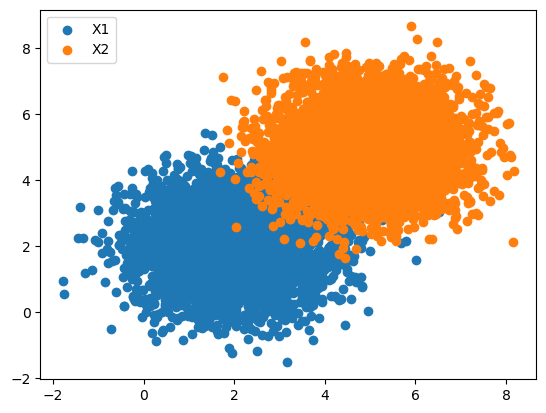

In [2]:
##
# Construct matrix X:
#
mean_X1 = (2,2)
cov_X1 = np.array([[1, 0], [0, 1]])
X1 = np.random.multivariate_normal(mean_X1, cov_X1, size = 5000)

mean_X2 = (5,5)
cov_X2 = np.array([[1, 0], [0, 1]])
X2 = np.random.multivariate_normal(mean_X2, cov_X2, size = 5000)

X = np.concatenate((X1,X2), axis = 0)

##
# Construct matrix Y:
#
Y1 = np.zeros(X1.shape[0])
Y2 = np.ones(X2.shape[0])

Y = np.concatenate((Y1, Y2), axis = 0)

##
# Sanity check:
#
print(X.shape)
print(Y.shape)

fig, axs = plt.subplots()
axs.scatter(x = X1[ : , 0], y = X1[ : , 1], label = 'X1')
axs.scatter(x = X2[ : , 0], y = X2[ : , 1], label = 'X2')
axs.legend()
plt.show()

(8067, 2)
(1933, 2)


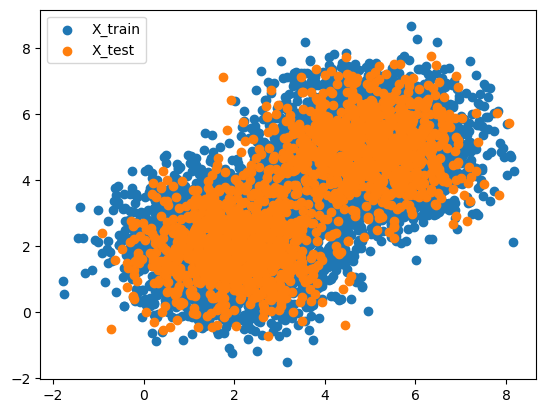

In [3]:
##
# Partition X and Y into training and test sets:
#
cutoff = 0.8
mask = np.random.rand(X.shape[0]) < cutoff
X_train = X[mask]
X_test = X[np.logical_not(mask)]

Y_train = Y[mask]
Y_test = Y[np.logical_not(mask)]

##
# Sanity check
#
print(X_train.shape)
print(X_test.shape)
fig, axs = plt.subplots()
axs.scatter(x = X_train[ : , 0], y = X_train[ : , 1], label = 'X_train')
axs.scatter(x = X_test[ : , 0], y = X_test[ : , 1], label = 'X_test')
axs.legend()
plt.show()

### Problem 3

In [4]:
def LLS(X,Y):
    """
    Construct the maximum-likelihood linear least squares function (Y = beta * X).
    """
    X_T = np.transpose(X)
    beta = np.dot(np.dot(np.linalg.inv(np.dot(X_T, X)), X_T), Y)
    return beta

def LLS_classify(X, beta, threshold: float):
    """
    Classify the elements of a set using the linear least square function with a threshold.
    """
    Yhat = np.dot(X, beta)
    Yhat = np.where(Yhat < threshold, 0, 1)
    return Yhat

def get_elements_from_training_set(X_train, Y_train, class_Y: int):
    """
    Get training set elements from a user-defined class.
    """
    return X_train[Y_train == class_Y, :]

def get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, class_Y: int):
    """
    Get correctly classified test set elements from a user-defined class.
    """
    class_corrected = []
    for i in range(0, Y_test.shape[0]):
        if Y_test[i] == class_Y:
            if Yhat_test[i] == Y_test[i]:
                class_corrected.append(i)
    
    return X_test[class_corrected, :]

def get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, class_Y: int):
    """
    Get incorrectly classified test set elements from a user-defined class.
    """
    class_incorrected = []
    for i in range(0, Y_test.shape[0]):
        if Y_test[i] == class_Y:
            if Yhat_test[i] != Y_test[i]:
                class_incorrected.append(i)
                
    return X_test[class_incorrected, :]

def compute_classifier_accuracy(X, Y, Yhat):
    """
    Compute the accuracy of a binary classifier.
    """
    class_1_corrected = get_corrected_elements_from_test_set(X, Y, Yhat, 1)
    class_0_corrected = get_corrected_elements_from_test_set(X, Y, Yhat, 0)
    accuracy = (class_1_corrected.shape[0] + class_0_corrected.shape[0]) / X.shape[0]
    return accuracy

0.9627521986549405


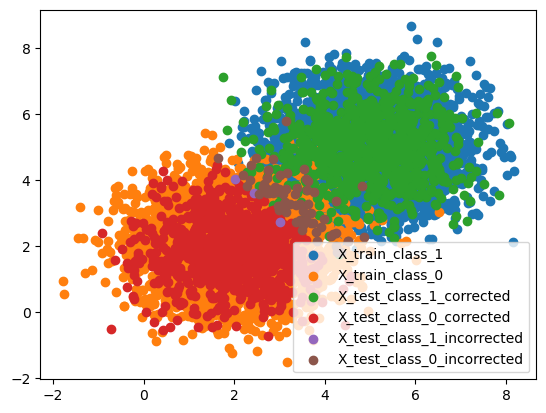

(2,)
(1933,)
(4034, 2)
(4033, 2)
(963, 2)
(898, 2)
(3, 2)
(69, 2)


In [5]:
##
# Construct a linear least square function:
#
beta = LLS(X_train, Y_train)

##
# Classify elements in the test set:
#
Yhat_test = LLS_classify(X_test, beta, 0.5)

##
# Get elements from training set:
#
X_train_class_1 = get_elements_from_training_set(X_train, Y_train, 1)
X_train_class_0 = get_elements_from_training_set(X_train, Y_train, 0)

##
# Get elements from test set:
#
X_test_class_1_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)
X_test_class_1_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)

##
# Compute the accuracy:
#
accuracy = compute_classifier_accuracy(X_test, Y_test, Yhat_test)
print(accuracy)

##
# Plot elements of sets:
#
fig, axs = plt.subplots()
axs.scatter(x = X_train_class_1[ : , 0], y = X_train_class_1[ : , 1], label = 'X_train_class_1')
axs.scatter(x = X_train_class_0[ : , 0], y = X_train_class_0[ : , 1], label = 'X_train_class_0')
axs.scatter(x = X_test_class_1_corrected[ : , 0], y = X_test_class_1_corrected[ : , 1], 
            label = 'X_test_class_1_corrected')
axs.scatter(x = X_test_class_0_corrected[ : , 0], y = X_test_class_0_corrected[ : , 1],
            label = 'X_test_class_0_corrected')
axs.scatter(x = X_test_class_1_incorrected[ : , 0], y = X_test_class_1_incorrected[ : , 1],
            label = 'X_test_class_1_incorrected')
axs.scatter(x = X_test_class_0_incorrected[ : , 0], y = X_test_class_0_incorrected[ : , 1],
            label = 'X_test_class_0_incorrected')
axs.legend(loc = 'lower right')
plt.show()

##
# Sanity check:
#
print(beta.shape)
print(Yhat_test.shape)
print(X_train_class_1.shape)
print(X_train_class_0.shape)
print(X_test_class_1_corrected.shape)
print(X_test_class_0_corrected.shape)
print(X_test_class_1_incorrected.shape)
print(X_test_class_0_incorrected.shape)


### Problem 4

0.975168132436627


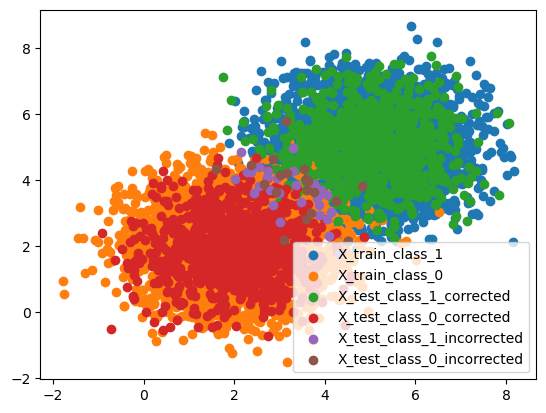

(2,)
(1933,)
(4034, 2)
(4033, 2)
(937, 2)
(948, 2)
(29, 2)
(19, 2)


In [6]:
##
# Construct a kD tree from the training set:
#
tree = cKDTree(X_train)

##
# Use the tree to classify the test set:
#
_ , indices = tree.query(X_test)
Yhat_test = Y_train[indices]

##
# Get elements from test set:
#
X_test_class_1_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)
X_test_class_1_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)

##
# Compute the accuracy:
#
accuracy = compute_classifier_accuracy(X_test, Y_test, Yhat_test)
print(accuracy)

##
# Plot elements of sets:
#
fig, axs = plt.subplots()
axs.scatter(x = X_train_class_1[ : , 0], y = X_train_class_1[ : , 1], label = 'X_train_class_1')
axs.scatter(x = X_train_class_0[ : , 0], y = X_train_class_0[ : , 1], label = 'X_train_class_0')
axs.scatter(x = X_test_class_1_corrected[ : , 0], y = X_test_class_1_corrected[ : , 1], 
            label = 'X_test_class_1_corrected')
axs.scatter(x = X_test_class_0_corrected[ : , 0], y = X_test_class_0_corrected[ : , 1],
            label = 'X_test_class_0_corrected')
axs.scatter(x = X_test_class_1_incorrected[ : , 0], y = X_test_class_1_incorrected[ : , 1],
            label = 'X_test_class_1_incorrected')
axs.scatter(x = X_test_class_0_incorrected[ : , 0], y = X_test_class_0_incorrected[ : , 1],
            label = 'X_test_class_0_incorrected')
axs.legend(loc = 'lower right')
plt.show()

##
# Sanity check:
#
print(beta.shape)
print(Yhat_test.shape)
print(X_train_class_1.shape)
print(X_train_class_0.shape)
print(X_test_class_1_corrected.shape)
print(X_test_class_0_corrected.shape)
print(X_test_class_1_incorrected.shape)
print(X_test_class_0_incorrected.shape)


### Problem 5

(8058, 2)
(1942, 2)


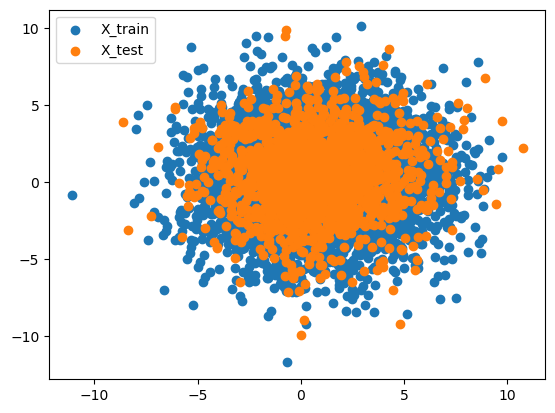

In [16]:
##
# Create 10 different overlapping Gaussian distributions:
#
seed = 28
np.random.seed(28)

means = [[x1, x2] for x1, x2 in zip(np.random.rand(10), np.random.rand(10))]
covs = [[[i + 1, 0], [0, i + 1]] for i in range(10)]
X = [np.random.multivariate_normal(mean, cov, 1000) for mean, cov in zip(means, covs)]

##
# Create X:
#
X = np.vstack(X)

##
# Create Y:
#
Y = np.zeros(10000)
Y[5000:] = 1

##
# Partition X and Y into training and test sets:
#
cutoff = 0.8
mask = np.random.rand(X.shape[0]) < cutoff
X_train = X[mask]
X_test = X[np.logical_not(mask)]

Y_train = Y[mask]
Y_test = Y[np.logical_not(mask)]

## 
# Sanity check:
#
print(X_train.shape)
print(X_test.shape)
fig, axs = plt.subplots()
axs.scatter(x = X_train[ : , 0], y = X_train[ : , 1], label = 'X_train')
axs.scatter(x = X_test[ : , 0], y = X_test[ : , 1], label = 'X_test')
axs.legend()
plt.show()

0.5030895983522142


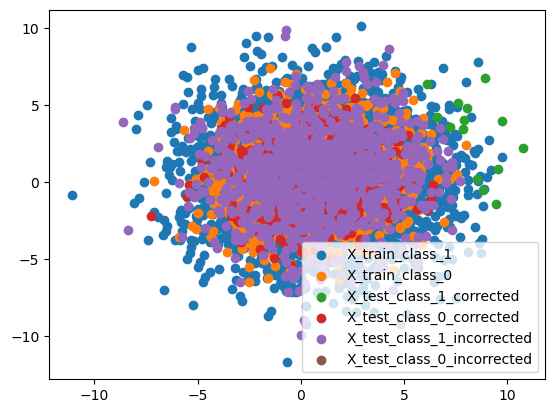

(2,)
(1942,)
(4021, 2)
(4037, 2)
(14, 2)
(963, 2)
(965, 2)
(0, 2)


In [17]:
##
# Perform linear classification:
#
beta = LLS(X_train, Y_train)
Yhat_test = LLS_classify(X_test, beta, 0.5)

##
# Get elements from training set:
#
X_train_class_1 = get_elements_from_training_set(X_train, Y_train, 1)
X_train_class_0 = get_elements_from_training_set(X_train, Y_train, 0)

##
# Get elements from test set:
#
X_test_class_1_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)
X_test_class_1_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)

##
# Compute the accuracy:
#
accuracy = compute_classifier_accuracy(X_test, Y_test, Yhat_test)
print(accuracy)

##
# Plot elements of sets:
#
fig, axs = plt.subplots()
axs.scatter(x = X_train_class_1[ : , 0], y = X_train_class_1[ : , 1], label = 'X_train_class_1')
axs.scatter(x = X_train_class_0[ : , 0], y = X_train_class_0[ : , 1], label = 'X_train_class_0')
axs.scatter(x = X_test_class_1_corrected[ : , 0], y = X_test_class_1_corrected[ : , 1], 
            label = 'X_test_class_1_corrected')
axs.scatter(x = X_test_class_0_corrected[ : , 0], y = X_test_class_0_corrected[ : , 1],
            label = 'X_test_class_0_corrected')
axs.scatter(x = X_test_class_1_incorrected[ : , 0], y = X_test_class_1_incorrected[ : , 1],
            label = 'X_test_class_1_incorrected')
axs.scatter(x = X_test_class_0_incorrected[ : , 0], y = X_test_class_0_incorrected[ : , 1],
            label = 'X_test_class_0_incorrected')
axs.legend(loc = 'lower right')
plt.show()

##
# Sanity check:
#
print(beta.shape)
print(Yhat_test.shape)
print(X_train_class_1.shape)
print(X_train_class_0.shape)
print(X_test_class_1_corrected.shape)
print(X_test_class_0_corrected.shape)
print(X_test_class_1_incorrected.shape)
print(X_test_class_0_incorrected.shape)


0.576725025746653


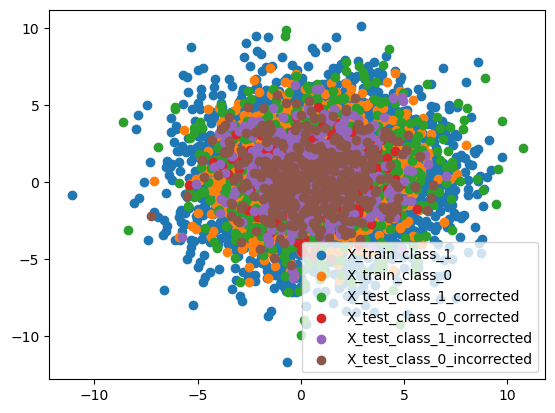

(2,)
(1942,)
(4021, 2)
(4037, 2)
(560, 2)
(560, 2)
(419, 2)
(403, 2)


In [18]:
##
# Perform kDTree's classification:
#
tree = cKDTree(X_train)

##
# Use the tree to classify the test set:
#
_ , indices = tree.query(X_test)
Yhat_test = Y_train[indices]

##
# Get elements from test set:
#
X_test_class_1_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_corrected = get_corrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)
X_test_class_1_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 1)
X_test_class_0_incorrected = get_incorrected_elements_from_test_set(X_test, Y_test, Yhat_test, 0)

##
# Compute the accuracy:
#
accuracy = compute_classifier_accuracy(X_test, Y_test, Yhat_test)
print(accuracy)

##
# Plot elements of sets:
#
fig, axs = plt.subplots()
axs.scatter(x = X_train_class_1[ : , 0], y = X_train_class_1[ : , 1], label = 'X_train_class_1')
axs.scatter(x = X_train_class_0[ : , 0], y = X_train_class_0[ : , 1], label = 'X_train_class_0')
axs.scatter(x = X_test_class_1_corrected[ : , 0], y = X_test_class_1_corrected[ : , 1], 
            label = 'X_test_class_1_corrected')
axs.scatter(x = X_test_class_0_corrected[ : , 0], y = X_test_class_0_corrected[ : , 1],
            label = 'X_test_class_0_corrected')
axs.scatter(x = X_test_class_1_incorrected[ : , 0], y = X_test_class_1_incorrected[ : , 1],
            label = 'X_test_class_1_incorrected')
axs.scatter(x = X_test_class_0_incorrected[ : , 0], y = X_test_class_0_incorrected[ : , 1],
            label = 'X_test_class_0_incorrected')
axs.legend(loc = 'lower right')
plt.show()

##
# Sanity check:
#
print(beta.shape)
print(Yhat_test.shape)
print(X_train_class_1.shape)
print(X_train_class_0.shape)
print(X_test_class_1_corrected.shape)
print(X_test_class_0_corrected.shape)
print(X_test_class_1_incorrected.shape)
print(X_test_class_0_incorrected.shape)